# Future Blood Shortage Forecasting — Notebook

This notebook walks through building a forecasting system to predict blood shortages by blood type and region.

**Contents:**

1. Imports & helper functions
2. Simulate multi-region, multi-blood-type historical data (daily)
3. Aggregate to weekly series and create shortage labels
4. Baseline forecasting (naive, moving average)
5. SARIMA (statsmodels) per-series modeling
6. Prophet (optional) modeling with uncertainty intervals
7. LSTM example (optional) for many-series forecasting
8. Evaluate regression (MAE/RMSE/MAPE) and classification (shortage detection metrics)
9. Save forecasts and next steps for deployment

**Note:** This notebook is self-contained and designed to be run locally. Some libraries (prophet, tensorflow) may need installation.


In [1]:
# 1) Imports
import os
import math
import random
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import joblib

print('ready: numpy', np.__version__, 'pandas', pd.__version__)


ready: numpy 2.0.2 pandas 2.2.2


In [2]:
# Helper functions
def create_date_range(start_date, end_date, freq='D'):
    return pd.date_range(start=start_date, end=end_date, freq=freq)

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.any() else np.nan

def classification_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0)
    }


In [3]:
# 2) Simulate multi-region, multi-blood-type daily data
random.seed(42)
np.random.seed(42)

start_date = datetime.utcnow() - timedelta(days=365*2)  # 2 years history
end_date = datetime.utcnow()
dates = create_date_range(start_date, end_date, freq='D')

regions = ['North','South','East','West']
blood_types = ['A+','A-','B+','B-','O+','O-','AB+','AB-']

rows = []
for region in regions:
    # region-level seasonality (yearly) and trend
    region_trend = random.uniform(-0.0005, 0.001)  # small drift
    seasonality_amplitude = random.uniform(10, 30)
    for bt in blood_types:
        base_level = random.randint(20, 80)  # base daily donation count
        for i, d in enumerate(dates):
            day_of_year = d.timetuple().tm_yday
            # yearly seasonality (sinusoidal)
            seasonal = seasonality_amplitude * math.sin(2 * math.pi * day_of_year / 365.25)
            # weekly seasonality (weekend effect)
            weekly = -5 if d.weekday() >=5 else 0
            # random noise
            noise = np.random.normal(scale=5.0)
            # occasional campaigns or shocks
            campaign = 0
            if random.random() < 0.005:  # rare campaign event
                campaign = random.randint(30,100)
            donations = max(0, base_level + seasonal + weekly + noise + campaign + region_trend * i)
            # requests roughly correlated with population + noise
            requests = max(0, base_level * random.uniform(0.8,1.2) + seasonal*0.5 + np.random.normal(scale=6.0))
            rows.append({'date': d, 'region': region, 'blood_type': bt, 'donations': donations, 'requests': requests})

df = pd.DataFrame(rows)
df['donations'] = df['donations'].round().astype(int)
df['requests'] = df['requests'].round().astype(int)
df['net'] = df['donations'] - df['requests']
df.head()


,date,region,blood_type,donations,requests,net
0,2023-08-12 17:08:58.488189,North,A+,28,27,1
1,2023-08-13 17:08:58.488189,North,A+,28,46,-18
2,2023-08-14 17:08:58.488189,North,A+,29,33,-4
3,2023-08-15 17:08:58.488189,North,A+,38,32,6
4,2023-08-16 17:08:58.488189,North,A+,27,38,-11


In [4]:
# 3) Aggregate to weekly series and create shortage labels
df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly = df.groupby(['region','blood_type','week']).agg({'donations':'sum','requests':'sum'}).reset_index()
weekly['net'] = weekly['donations'] - weekly['requests']
# shortage if net < 0 (you can tune threshold)
weekly['shortage'] = (weekly['net'] < 0).astype(int)
print('Weekly series rows:', len(weekly))
weekly.head()


Weekly series rows: 3392


,region,blood_type,week,donations,requests,net,shortage
0,East,A+,2023-08-07,39,82,-43,1
1,East,A+,2023-08-14,185,242,-57,1
2,East,A+,2023-08-21,166,242,-76,1
3,East,A+,2023-08-28,166,273,-107,1
4,East,A+,2023-09-04,167,234,-67,1


In [5]:
# 4) Baseline forecasts: naive (last value) and simple moving average
def naive_forecast(series, horizon=4):
    last = series.iloc[-1]
    return np.array([last] * horizon)

def moving_average_forecast(series, window=4, horizon=4):
    ma = series.rolling(window=window).mean().iloc[-1]
    return np.array([ma] * horizon)

# Demo: pick one series
sample = weekly[(weekly['region']=='North') & (weekly['blood_type']=='O+')].sort_values('week')
series = sample['net'].reset_index(drop=True)
horizon = 4
naive = naive_forecast(series, horizon)
ma = moving_average_forecast(series, window=8, horizon=horizon)
print('Naive', naive, 'MA', ma)


Naive [-5 -5 -5 -5] MA [-9.875 -9.875 -9.875 -9.875]


Training SARIMA on a sample series — this is computationally heavier for many series


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA RMSE: 35.79268739354566


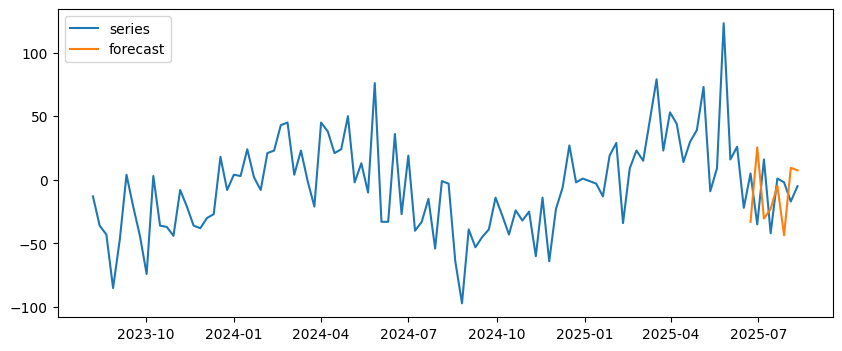

In [6]:
# 5) SARIMA modeling per series (statsmodels)
print('Training SARIMA on a sample series — this is computationally heavier for many series')
try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
except Exception as e:
    print('statsmodels not installed or import failed:', e)

# Fit SARIMA on sample series
sample = weekly[(weekly['region']=='North') & (weekly['blood_type']=='O+')].sort_values('week')
series = sample.set_index('week')['net']
train = series.iloc[:-8]
test = series.iloc[-8:]
model = None
try:
    # simple SARIMA order; in practice grid-search for order (p,d,q)(P,D,Q,s)
    sar = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,52), enforce_stationarity=False, enforce_invertibility=False)
    res = sar.fit(disp=False)
    pred = res.get_forecast(steps=8)
    fc = pred.predicted_mean
    ci = pred.conf_int()
    print('SARIMA RMSE:', rmse(test.values, fc.values))
    # plot quick
    try:
        plt.figure(figsize=(10,4)); plt.plot(series.index, series.values, label='series'); plt.plot(fc.index, fc.values, label='forecast'); plt.legend(); plt.show()
    except Exception:
        pass
except Exception as e:
    print('SARIMA fit failed (maybe statsmodels missing):', e)


In [7]:
# 6) Prophet forecasting (optional) — easy trend & seasonality + holiday handling
print('Prophet (if installed) example')
try:
    from prophet import Prophet
    use_prophet = True
except Exception as e:
    print('prophet not installed or import failed:', e)
    use_prophet = False

if use_prophet:
    sample = weekly[(weekly['region']=='North') & (weekly['blood_type']=='O+')].sort_values('week')
    dfp = sample[['week','net']].rename(columns={'week':'ds','net':'y'})
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(dfp)
    future = m.make_future_dataframe(periods=8, freq='W')
    forecast = m.predict(future)
    print('Prophet forecast head:'); print(forecast[['ds','yhat','yhat_lower','yhat_upper']].tail())


Prophet (if installed) example


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8pcgyro8/ouq0irms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8pcgyro8/vfe4_p7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80914', 'data', 'file=/tmp/tmp8pcgyro8/ouq0irms.json', 'init=/tmp/tmp8pcgyro8/vfe4_p7m.json', 'output', 'file=/tmp/tmp8pcgyro8/prophet_modelf3pkyebc/prophet_model-20250811170911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet forecast head:
            ds       yhat  yhat_lower  yhat_upper
109 2025-09-07 -38.722048  -68.997979  -11.227056
110 2025-09-14 -22.342111  -53.749982    5.747061
111 2025-09-21 -17.391420  -45.815039   10.827589
112 2025-09-28 -23.284936  -52.496700    4.521772
113 2025-10-05 -29.445008  -58.768564   -2.162898


In [8]:
# 7) LSTM example (optional): prepare data for sequence model
print('LSTM example uses tensorflow/keras if installed — may be slow locally')
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    use_tf = True
except Exception as e:
    print('TensorFlow not available:', e)
    use_tf = False

if use_tf:
    # Prepare a single series for demonstration
    s = series.values.astype(float)
    # simple sliding window
    window = 8
    Xs, ys = [], []
    for i in range(len(s)-window):
        Xs.append(s[i:i+window])
        ys.append(s[i+window])
    Xs = np.array(Xs)[:, :, np.newaxis]
    ys = np.array(ys)
    split = int(0.8*len(Xs))
    Xtr, Xte = Xs[:split], Xs[split:]
    ytr, yte = ys[:split], ys[split:]
    model = Sequential([LSTM(32, input_shape=(window,1)), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    model.fit(Xtr, ytr, epochs=20, validation_data=(Xte, yte), verbose=2)
    preds = model.predict(Xte).flatten()
    print('LSTM RMSE:', rmse(yte, preds))


LSTM example uses tensorflow/keras if installed — may be slow locally
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 3s - 1s/step - loss: 1220.1530 - val_loss: 1671.8879
Epoch 2/20
3/3 - 0s - 33ms/step - loss: 1213.9075 - val_loss: 1668.4713
Epoch 3/20
3/3 - 0s - 33ms/step - loss: 1208.5579 - val_loss: 1665.4801
Epoch 4/20
3/3 - 0s - 47ms/step - loss: 1203.1504 - val_loss: 1662.7650
Epoch 5/20
3/3 - 0s - 35ms/step - loss: 1198.4963 - val_loss: 1660.2566
Epoch 6/20
3/3 - 0s - 32ms/step - loss: 1194.5081 - val_loss: 1658.1211
Epoch 7/20
3/3 - 0s - 34ms/step - loss: 1190.3630 - val_loss: 1656.1322
Epoch 8/20
3/3 - 0s - 46ms/step - loss: 1186.7107 - val_loss: 1654.1442
Epoch 9/20
3/3 - 0s - 46ms/step - loss: 1183.0555 - val_loss: 1652.0627
Epoch 10/20
3/3 - 0s - 35ms/step - loss: 1180.1047 - val_loss: 1650.1090
Epoch 11/20
3/3 - 0s - 30ms/step - loss: 1176.2560 - val_loss: 1648.2859
Epoch 12/20
3/3 - 0s - 53ms/step - loss: 1173.2570 - val_loss: 1646.2473
Epoch 13/20
3/3 - 0s - 33ms/step - loss: 1170.0453 - val_loss: 1643.8477
Epoch 14/20
3/3 - 0s - 32ms/step - loss: 1166.9551 - val_loss: 1641.2135


In [9]:
# 8) Evaluate forecasting as regression and as shortage-classification
# We'll do a simple backtest across multiple series: walk-forward per series using moving average and SARIMA if available
from tqdm import tqdm
results = []
series_groups = weekly.groupby(['region','blood_type'])
for (region, bt), grp in series_groups:
    s = grp.sort_values('week')
    vals = s['net'].values
    if len(vals) < 52:
        continue
    # train/test split (last 12 weeks test)
    train_vals = vals[:-12]
    test_vals = vals[-12:]
    # baseline MA forecast
    ma_fore = np.array([train_vals[-8:].mean()] * len(test_vals))
    mae_ma = mean_absolute_error(test_vals, ma_fore)
    rmse_ma = rmse(test_vals, ma_fore)
    # shortage classification (threshold net<0)
    y_true_short = (test_vals < 0).astype(int)
    y_pred_short = (ma_fore < 0).astype(int)
    metrics_short = classification_metrics(y_true_short, y_pred_short)
    results.append({'region':region,'blood_type':bt,'ma_mae':mae_ma,'ma_rmse':rmse_ma,'short_acc':metrics_short['accuracy'],'short_prec':metrics_short['precision'],'short_rec':metrics_short['recall']})

res_df = pd.DataFrame(results)
res_df.describe().T


,count,mean,std,min,25%,50%,75%,max
ma_mae,32.0,66.841797,21.557600,28.250000,48.921875,70.322917,80.234375,109.583333
ma_rmse,32.0,75.318859,22.368898,33.092358,56.755548,80.285399,91.312814,118.318690
short_acc,32.0,0.437500,0.113986,0.166667,0.395833,0.500000,0.500000,0.583333
short_prec,32.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
short_rec,32.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
# 9) Save examples of forecasts and artifacts
os.makedirs('/mnt/data/models_forecast', exist_ok=True)
# Save weekly aggregated data
weekly.to_csv('/mnt/data/models_forecast/weekly_series.csv', index=False)
joblib.dump({'weekly': weekly}, '/mnt/data/models_forecast/weekly_artifact.joblib')
print('Saved weekly series and artifacts to /mnt/data/models_forecast')


Saved weekly series and artifacts to /mnt/data/models_forecast


## Next steps & production notes

1. **Model selection**: For many series, tree-based models on lag features or global models (DeepAR, TFT, N-HiTS) often outperform isolated SARIMA.

2. **Uncertainty**: Use prediction intervals (Prophet, SARIMAX conf_int, bootstrap) to compute risk of shortage probabilistically.

3. **Thresholding**: Convert numeric forecasts to shortage alerts using business thresholds (e.g., if expected net <-X units or probability > p).

4. **Hierarchical forecasting**: Forecast at hospital-level or blood-type-level and reconcile to region/aggregate levels.

5. **Deployment**: schedule daily/weekly batch forecasts; store results in DB; create dashboards; trigger donor mobilization workflow linking to the responders model.

6. **Monitoring**: track MAE, RMSE per series; set alerts when error increases (model drift).

7. **Data**: enrich with exogenous features (holidays, campaigns, local outbreaks, weather).

Download the outputs from `/mnt/data/models_forecast/` after running the notebook locally.
